In [22]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
import time
from yahooquery import Ticker
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 9999)
pd.set_option('display.max_rows', 9999)

### Import Trades from file generated by code and create Prices dataframe

In [39]:
# Read generated buys
trades = pd.read_feather('../output/trades.feather')
trades = trades.drop_duplicates()
trades['just_date'] = pd.to_datetime(trades['just_date'])

# Remove some rows
columns = []
for column in trades.columns:
    if 'signal' in column:
        columns.append(column)

In [40]:
# create pairs
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
lst = chunks(columns, 2)
pair_of_signals = [i for i in lst]

In [41]:
# Prices
prices_base = trades[['just_date', 'symbol', 'close_price_x']].dropna(subset=['close_price_x'])

In [42]:
business_days = prices_base['just_date'].unique()

In [43]:
# Convert data time
trades['just_date'] = pd.to_datetime(trades['just_date'])

# Update trades to merge with earnings
# Create dataframe with all dates and symbols
# Find list of unique symbols, max and min dates
list_of_symbols = trades['symbol'].unique()
max_date = trades['just_date'].max()
min_date = trades['just_date'].min()

# Create empty list to store results
lst_of_dates = []

# Moving date will be added to the list and initially is the min_date
moving_date = min_date

# While the statement is true, keep adding one day to moving date and add it to list
while moving_date <= max_date:
    lst_of_dates.append(moving_date)
    moving_date = moving_date + timedelta(days=1)

# Create a DataFrame from this and create a dataframe with all symbols
all_dates_df = pd.DataFrame(lst_of_dates, columns=['just_date'])
all_symbols = pd.DataFrame(list_of_symbols, columns=['symbol'])

# Dummy columns to do a cross join
all_dates_df['key'] = 0
all_symbols['key'] = 0

# Merge on dummy column
all_dates_df = all_dates_df.merge(all_symbols, on='key', how='outer')
all_dates_df = all_dates_df[['just_date', 'symbol']]

# Update trades dataframe
trades = pd.merge(all_dates_df, trades, on=['just_date', 'symbol'], how='left')

# Read Earnings
earnings = pd.read_csv('../docs/earnings.csv')
earnings['earnings_date'] = pd.to_datetime(earnings['earnings_date']).dt.date
earnings['earnings_date_60d'] = pd.to_datetime(earnings['earnings_date']) - timedelta(days=60)

# Merge with trades
trades = pd.merge(trades, earnings, how='left', left_on=['symbol', 'just_date'], right_on=['symbol', 'earnings_date_60d'])

trades['earnings_date'] = trades.groupby('symbol').ffill()['earnings_date']
trades['earnings_date'] = pd.to_datetime(trades['earnings_date'])
trades['earnings_difference'] = trades['just_date'] - trades['earnings_date']
trades['earnings_difference'] = trades['earnings_difference'].dt.days

# Add Previous day price column for Trailing Loss calculation
trades['previous_day_price'] = trades.groupby(['symbol']).shift(1)['close_price_x']

# Drop Columns
trades.drop(columns=['earnings_date_60d', 'earnings_date'], inplace=True)

# Remove unecessary rows
trades = trades[trades[columns].any(axis='columns')]

### Import Earnings

In [44]:
# Update trades to merge with earnings
# Create dataframe with all dates and symbols
# Find list of unique symbols, max and min dates
list_of_symbols = trades['symbol'].unique()
max_date = trades['just_date'].max()
min_date = trades['just_date'].min()

# Create empty list to store results
lst_of_dates = []

# Moving date will be added to the list and initially is the min_date
moving_date = min_date

# While the statement is true, keep adding one day to moving date and add it to list
while moving_date <= max_date:
    lst_of_dates.append(moving_date)
    moving_date = moving_date + timedelta(days=1)
    
# Create a DataFrame from this and create a dataframe with all symbols
all_dates_df = pd.DataFrame(lst_of_dates, columns=['just_date'])
all_symbols = pd.DataFrame(list_of_symbols, columns=['symbol'])

# Dummy columns to do a cross join
all_dates_df['key'] = 0
all_symbols['key'] = 0

# Merge on dummy column
all_dates_df = all_dates_df.merge(all_symbols, on='key', how='outer')
all_dates_df = all_dates_df[['just_date', 'symbol']]

# Update trades dataframe
trades = pd.merge(all_dates_df, trades, on=['just_date', 'symbol'], how='left')

In [45]:
# Read Earnings
earnings = pd.read_csv('../docs/earnings.csv')
earnings['earnings_date'] = pd.to_datetime(earnings['earnings_date']).dt.date
earnings['earnings_date_60d'] = pd.to_datetime(earnings['earnings_date']) - timedelta(days=60)

# Merge with trades
trades = pd.merge(trades, earnings, how='left', left_on=['symbol', 'just_date'], right_on=['symbol', 'earnings_date_60d'])
trades['earnings_date'] = trades.groupby(['symbol']).ffill()['earnings_date']
trades['earnings_date'] = pd.to_datetime(trades['earnings_date'])
trades['earnings_difference'] = trades['just_date'] - trades['earnings_date']
trades['earnings_difference'] = trades['earnings_difference'].dt.days

# Add Previous day price column for Trailing Loss calculation
trades['previous_day_price'] = trades.groupby(['symbol']).shift(1)['close_price_x']

# Drop Columns
trades.drop(columns=['earnings_date_60d', 'earnings_date'], inplace=True)

In [46]:
# Remove unecessary rows
trades = trades[trades[columns].any(axis='columns')]

## S&P

In [47]:
sp = Ticker('SPY')
sp = sp.history(start='2016-01-01', interval='1d')
sp['daily_returns'] = sp['close'].pct_change()
sp['daily_returns'] = sp['daily_returns'] + 1
sp['running_return'] = sp['daily_returns'].cumprod() - 1
sp = sp.reset_index()
sp['index'] = pd.to_datetime(sp['index']).dt.date
sp = sp.set_index('index')

### Create DataFrames of Buys and Sells
#### Buys

In [48]:
def extract_buys(df
                 , pair_of_signals
                 , buy_date
                 , cash_per_trade
                 , balances
                 , drawdown_condition
                 , days_since_last_drawdown
                 , drawdown_days
                 , drawdown_ramp_up_days
                 , drawdown_ramp_up_perc
                 , current_holdings_symbols = []):
    
    # Create empty list to store results
    buys_list = []
    
    # Final balances
    final_balances = []
    
    # Columns
    columns_list = ['symbol', 'date', 'price', 'order_type', 'shares', 'total', 'strategy']
    
    # Empty dataframe
    empty_df = pd.DataFrame([[0,0,0,0,0,0]], columns = ['symbol', 'date', 'price', 'order_type', 'shares', 'total'])
    
    # Loop through different strategies
    for idx, item in enumerate(pair_of_signals):
        
        #Define buy and sell signals
        buy_signal = item[0]
        sell_signal = item[1]
        
        # Reset exclude symbols
        exclude_symbols = []
        
        # Initial balance
        current_balance = balances[idx]
        
        # Calculate drawdown balance
        if (days_since_last_drawdown[idx] >= drawdown_days) & (days_since_last_drawdown[idx] < 2 * drawdown_days):
            if (days_since_last_drawdown[idx] - drawdown_days) % drawdown_ramp_up_days == 0:
                drawdown_balance = current_balance * drawdown_ramp_up_perc
            else:
                drawdown_balance = 0
                
            remaining_balance = current_balance - drawdown_balance
        else:
            drawdown_balance = current_balance
            remaining_balance = 0
        
        # Calculate cash_per_trade
        
        if drawdown_condition[idx] == True:
            # Create dataframe with buys
            buys = df[(df['just_date'] == buy_date) 
                        & (~df['symbol'].isin(current_holdings_symbols))
                        & (df[buy_signal] == True)
                        & (df[sell_signal] != True)
                        & (~df['earnings_difference'].between(-20,-1))][['symbol', 'just_date', 'close_price_x']]

            # Check if there's enough money to buy
            for index, row in buys.iterrows():
                if drawdown_balance >= cash_per_trade:
                    drawdown_balance = drawdown_balance - cash_per_trade
                    current_balance = drawdown_balance + remaining_balance
                else:
                    exclude_symbols.append(row['symbol'])

            # Remove excluded symbols
            if len(exclude_symbols) > 0:
                buys = buys[~buys['symbol'].isin(exclude_symbols)]

        else:
            buys = df[df[buy_signal] == 'Nothing'][['symbol', 'just_date', 'close_price_x']]
        
        # Create some other columns
        buys['order_type'] = 'buy'
        buys['shares'] = cash_per_trade / buys['close_price_x']
        buys['total'] = buys['shares'] * buys['close_price_x']
        buys['strategy'] = buy_signal
        
        # Append current balance
        final_balances.append(current_balance)
        
        # If length is zero then create empty record
        if len(buys) == 0:
            buys_none = empty_df
            buys_none['strategy'] = buy_signal
            buys_list.append(buys_none.values.tolist()[0])
            
        # Else then append buys
        else:
            buys.columns = columns_list
            [buys_list.append(i) for i in buys.values.tolist()]
    
    # Transform list into a Dataframe
    buys_df = pd.DataFrame(buys_list, columns = columns_list)

    return buys_df, final_balances

### Sells

In [49]:
def extract_sells(trades, date, sell_signal):
    # Search for the sell_signal on a given day
    sells = trades[(trades['just_date'] == date) 
                & (trades[sell_signal] == True)][['symbol', 'just_date', 'close_price_x']]
    
    # Create Column with order type
    sells['order_type'] = 'sell'
    
    # Rename a columns
    sells.columns = ['symbol', 'sell_date', 'price', 'order_type']
    
    return sells

Create function to convert Backtest outputs into dataframes

In [50]:
def create_dataframes(holdings_list, list_of_balances, rgl_list, pair_of_signals):
    
    # Create DataFrame with holdings
    data_frame_list = [x for b in holdings_list for x in b]
    holdings_df = pd.DataFrame(data_frame_list)
    holdings_df.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis', 'as_of_date', 'day_close_price', 'market_value', '%_gain', 'holding_days']
    holdings_df['$_gain'] = holdings_df['market_value'] - holdings_df['cost_basis']
    
    # Create list to store rows with balances
    balances_to_df = []

    # Go through list of balances
    for row in list_of_balances:
        # Extract date from row
        date = row[-1]
        # for each pair of signals append balance
        [balances_to_df.append([signal_pair[0], row[idx], date]) for idx, signal_pair in enumerate(pair_of_signals)]

    # Create dataframe with cash balances
    balances_df = pd.DataFrame(balances_to_df, columns = ['strategy', 'market_value', 'as_of_date'])
    balances_df['symbol'] = 'CASH'
    
    # Create DataFrame with RGL data
    data_frame_list_rgl = [x for b in rgl_list for x in b]
    rgl_df = pd.DataFrame(data_frame_list_rgl)
    rgl_df.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis', 'as_of_date',
                      'day_close_price', 'order_type', 'price', 'sell_date', 'market_value', '$_gain', '%_gain']
    rgl_df = rgl_df[rgl_df['buy_date'] != 0]
    
    return holdings_df, balances_df, rgl_df

### Loop Through Days
Logic:
- See if there are any buys on that day and add to holdings_df if that's the case.
- See if there are any sells using the sell_signal and limits (max_loss and max_holdings).
- If you have sells, then remove them from holdings and add to rgl_df.

In [51]:
def backtester(trades,
               pair_of_signals,
               manual_dates = True,
               start_date = '2017-01-02',
               end_date = '2018-12-30',
               max_loss = -0.15,
               max_daily_loss = -0.10,
               max_holdings = 9999,
               max_gain = 0.40,
               max_daily_gain = 0.15,
               max_drawdown = 0.10,
               drawdown_days = 20,
               drawdown_ramp_up_days = 5,
               drawdown_ramp_up_perc = 0.2,
               initial_cash_balance = 5000,
               cash_per_trade = 100,
               monthly_deposit = 0):
    """
    This function is a backtesting tool that takes all trades (pd.DataFrame) and pair_of_signals (lst).
    Then based on all other arguments it will simulate the strategy and return the results of the simulation.

    Args:
        trades (pd.DataFrame): Dataframe with buy/sell signals for every security and every day. It's the output
                               of the main() function.
        pair_of_signals (lst): List with pair of signals. Only the signals in that list will be analyzed. The point
                               is to give the user the freedom of choosing which pairs to analyze.
        manual_dates (bool): Boolean field. If set to False it will run for the full set, if False, it will take the
                             start_date and end_date as the beginning/end of the analysis.
        start_date (str): Date in which the analysis will start.
        end_date (str): Date in which the analysis will end.
        max_loss (float): Negative float amount that represents the max loss that you're willing to take on any 
                          position (i.e. stop-loss). Ex: -0.15 = Max Loss of 15%.
        max_daily_loss (float): Negative float amount that represents how much you're willing to lose on a single-day
                                drop. Ex: -0.10, if the stock drops 10% or more in a single day, you sell it.
        max_holdings (int): Max number of days you want to hold a position, after that you sell it.
        max_gain (float): Float amount that represents the max gain you want to take in a position. Once it hits the
                          target, you will sell it (i.e. stop-gain). Ex: 0.15 = Max Gain of 15%.
        max_daily_gain (float): Float amount that represents max spike you're taking before selling the position.
                                For example, if a position goes up by 15% and your limit is 10%, you will sell it.
        max_drawdown (float): Max drop in your portfolio you will take before stopping trading. For xample, if 0.10 then
                            if the peak of your portfolio was $5000. Then once it goes below $5000 - $500 = $4500, 
                            you'll stop trading for drawdown_days.
        drawdown_days (int): No. of days you will stop trading once your portfolio goes below the max drawdown you're
                             willing to take, based on the portfolio's peak and max_drawdown.
        initial_cash_balance (int): Your portfolio initial cash balance.
        cash_per_trade (int): How much you'll invest per trade.
        monthly_deposit (int): Cash deposits that will be added to your cash balance at the beginning of every month.
          

    Returns:
        holdings_list (lst): Every day holdings for every strategy stored in a list.
        list_of_balances (lst): Every day cash balance for every strategy stored in a list.
        rgl_list (lst): Realized Gain/Loss for every sold position for every strategy.
    """
    
    # No. of signals
    no_of_signals = len(pair_of_signals)

    # Define Min, Max and Moving Dates
    for idx, signal in enumerate(pair_of_signals):
        if idx == 0:
            min_date = trades[trades[signal[0]] == True]['just_date'].min()
        else:
            compare_date = trades[trades[signal[0]] == True]['just_date'].min()
            if compare_date < min_date:
                min_date = compare_date
    
    # Define whether it will run on manual dates or everything
    if manual_dates == False:
        min_date = trades['just_date'].min()
        min_date = pd.to_datetime(min_date)
        max_date = trades['just_date'].max()
    else:
        # Custom Dates
        min_date = pd.to_datetime(start_date)
        max_date = pd.to_datetime(end_date)

    number_of_days = (max_date - min_date).days + 1
    count = 1

    # Result Lists
    holdings_list = []
    rgl_list = []

    # The moving date gives sells/buys on a given day.
    moving_date = min_date

    # Balances
    initial_balances = [initial_cash_balance for i in range(no_of_signals)]
    list_of_balances = []

    # Drawdown
    drawdown_beg = [True for i in range(no_of_signals)]
    days_since_last_drawdown_beg = [100 for i in range(no_of_signals)]

    # How much to add every month
    more_cash = [monthly_deposit for i in range(no_of_signals)]

    # Max loss and holdings
    #max_loss = -0.15 # Total position
    #max_daily_loss = 0.10 # Daily Loss
    #max_holdings = 9999

    # Max Gain
    #max_gain = 0.40 # Total 
    #max_daily_gain = 0.15 # Daily

    # Start Drawdown variables
    peak = np.array(initial_balances)
    today_mv = np.array(initial_balances)
    #max_drawdown = 0.10
    #drawdown_days = 20
    drawdown_dates = [min_date] * no_of_signals

    # Filename
    filename = '{} - {} - Max Total Loss {} - Max Day Drop {} - Max Total Gain {} - Max Day Gain {} - Max Holdings Days {}.csv'.format(min_date.strftime("%m:%d:%Y"), 
                                                                                                                                          max_date.strftime("%m:%d:%Y"), 
                                                                                                                                          str(max_loss),
                                                                                                                                          str(max_daily_loss),
                                                                                                                                          str(max_gain),
                                                                                                                                          str(max_daily_gain),
                                                                                                                                          str(max_holdings))
    # calendar
    calendar = []

    # While moving date is less or equal to max_date
    while moving_date <= max_date:

        # Week day
        weekday = moving_date.weekday()

        # On the first day of the month we will add more 100 bucks
        if (moving_date.day == 1) & (moving_date != start_date):
            # Add cash every month
            current_balances = [x + y for x, y in zip(current_balances, more_cash)]
            #balance_day = current_balances

        # Add to calendar
        calendar.append(moving_date)

        # Start tracking time
        start_time = time.time()

        # If it's the first date, the process is different, because holdings and rgl need to be created yet
        if moving_date == min_date:

            # Figure out buys
            buys, current_balances = extract_buys(trades, 
                                                  pair_of_signals=pair_of_signals, 
                                                  buy_date=moving_date, 
                                                  cash_per_trade=cash_per_trade, 
                                                  balances=initial_balances, 
                                                  drawdown_condition=drawdown_beg,
                                                  drawdown_days=drawdown_days,
                                                  drawdown_ramp_up_days=drawdown_ramp_up_days,
                                                  drawdown_ramp_up_perc=drawdown_ramp_up_perc,
                                                  days_since_last_drawdown=days_since_last_drawdown_beg)
            balance_day = current_balances
            balance_day.append('test')

            # Create holdings
            holdings_df = buys[['strategy', 'date', 'symbol', 'price', 'shares', 'total']]
            holdings_df.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis']

            # As of Date and close_price columns
            holdings_df['as_of_date'] = moving_date
            holdings_df['day_close_price'] = 0
            holdings_df['market_value'] = 0
            holdings_df['gains_$'] = 0
            holdings_df['holdings_days'] = 0

            # Convert symbols to string to avoid merging problems in the future
            holdings_df['symbol'] = holdings_df['symbol'].astype(str)

            # Holdings append
            holdings_list.append(holdings_df.values.tolist())

            # Create RGL
            rgl_df = holdings_df.copy()
            rgl_list.append(rgl_df.values.tolist())

        # If it's not the first day:
        else:

            # Create prices dataframe from trades
            prices = prices_base[prices_base['just_date'] == moving_date][['symbol', 'close_price_x']]
            prices.columns = ['symbol', 'day_close_price']

            # Get Previous Day's Holdings and store the number of securities held on that day

            #previous_holdings = temp_holdings[temp_holdings['as_of_date'] == previous_day]
            previous_holdings = pd.DataFrame(holdings_list[-1])

            previous_holdings.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 
                                         'cost_basis', 'date', 'previous_price', 'mkt', 'gain', 'holdings_days']

            previous_holdings = previous_holdings[['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 
                                         'cost_basis', 'previous_price', 'holdings_days']]


            # Drawdown check - Figure out Peak
            today_holdings = previous_holdings[['strategy', 'symbol', 'shares']]
            today_holdings['symbol'] = today_holdings['symbol'].astype(str)
            today_holdings = pd.merge(today_holdings, prices, on='symbol', how='left').fillna(0)
            today_holdings['today_mv'] = today_holdings['day_close_price'] * today_holdings['shares']
            today_holdings = today_holdings.groupby('strategy').sum()['today_mv'].values

            # List of symbols in holdings
            if len(previous_holdings) > 0:
                symbols_in_holdings = previous_holdings['symbol'].to_list()
            else:
                symbols_in_holdings = []

            if today_holdings.sum() != 0 and weekday < 5:
                today_mv = np.add(balance_day[:-1], today_holdings)
                peak_boolean_above = (today_mv - peak) >= 0
                peak_boolean_below = (today_mv - peak) < 0
                peak = (today_mv * peak_boolean_above) + (peak * peak_boolean_below)

            # Max Drawdown
            max_draw = peak * max_drawdown * -1
            differences = today_mv - peak# - yesterday_mv
            drawdown_boolean = differences < max_draw
            #print(peak, today_mv, max_draw, differences, drawdown_boolean, moving_date)

            #previous_holdings = previous_holdings.drop('day_close_price', axis=1)
            #previous_holdings.drop(['as_of_date'], axis=1, inplace=True)

            # Create Temporary RGL List to Append results from each strategy
            rgl_temp = []
            holdings_temp = []
            temp_balances = []

            # Loop through different strategies
            for idx, item in enumerate(pair_of_signals):

                #Signals
                buy_signal = item[0]
                sell_signal = item[1]

                # Reset value of sell
                money_from_sell = 0

                # Strategy Holdings
                strategy_holdings = previous_holdings[previous_holdings['strategy'] == buy_signal]

                # Check the number of Holdings symbols in a given strategy
                number_of_symbols = len(strategy_holdings['symbol'].unique())

                # Figure out sells and create list of symbols with sell signals
                sells = extract_sells(trades, moving_date, sell_signal=sell_signal)

                # Create list of symbols
                sold_symbols = set(sells['symbol'])

                # Remove sells from Previous Day's Holdings
                holdings_no_sells = strategy_holdings[~strategy_holdings['symbol'].isin(sold_symbols)]
                
                # Convert symbol column to string
                holdings_no_sells['symbol'] = holdings_no_sells['symbol'].astype(str)

                # Do the following with the securities that were left (only in business days)
                if (np.datetime64(moving_date) in business_days) and (len(holdings_no_sells) > 1):

                    # See which companies are about to announce earnings (we don't want to hold that)
                    earnings['moving_date'] = moving_date
                    max_date_earnings = moving_date + timedelta(days=5)
                    earnings['moving_date'] = pd.to_datetime(earnings['moving_date'])
                    earnings['earnings_date'] = pd.to_datetime(earnings['earnings_date'])
                    earnings['diff'] = earnings['earnings_date'] - earnings['moving_date']
                    earnings['diff'] = earnings['diff'].dt.days
                    announcing_earnings = set(earnings[(earnings['earnings_date'] > moving_date) & (earnings['earnings_date'] < max_date_earnings)]['symbol'])

                    # Create new sell signals based on max_loss and max_holdings
                    # Calculate % gain
                    stop_loss_sells = pd.merge(holdings_no_sells, prices, on='symbol', how='left')
                    stop_loss_sells['market_value'] = stop_loss_sells['shares'] * stop_loss_sells['day_close_price']
                    stop_loss_sells['%_gain'] = (stop_loss_sells['market_value'] / stop_loss_sells['cost_basis']) - 1
                    stop_loss_sells['daily_difference'] = stop_loss_sells['day_close_price'] - stop_loss_sells['previous_price']

                    # Create column with date and remove 0's from sells
                    stop_loss_sells['just_date'] = moving_date
                    stop_loss_sells = stop_loss_sells[stop_loss_sells['buy_date'] != 0]

                    # If sell signals were generated from this, then do the following
                    if len(stop_loss_sells) > 0:

                        # Calculate the number of Holding Days, which is the difference between buy_date and just_date
                        stop_loss_sells['holding_days'] = (stop_loss_sells['just_date'] - pd.to_datetime(stop_loss_sells['buy_date']))
                        stop_loss_sells['holding_days'] = stop_loss_sells['holding_days'].dt.days

                        # Check if drawdown condition was met
                        if drawdown_boolean[idx] == False:
                            stop_loss_sells['drawdown'] = False

                        else:
                            stop_loss_sells['drawdown'] = True
                            print('DRAWDOWN!!', moving_date, buy_signal)
                            peak[idx] = today_mv[idx]
                            # Update list with moving date + parole
                            drawdown_dates[idx] = moving_date + timedelta(days=drawdown_days)

                        # Create Sell Signal if % gain is below max_loss OR holding_days is greater then max_holdings
                        stop_loss_sells = stop_loss_sells[
                            (stop_loss_sells['%_gain'] < max_loss)
                           |(stop_loss_sells['%_gain'] > max_gain)
                           |(stop_loss_sells['holding_days'] > max_holdings)
                           |(stop_loss_sells['symbol'].isin(announcing_earnings))
                           |(stop_loss_sells['drawdown'] == True)
                           |(stop_loss_sells['daily_difference'] > (cash_per_trade * max_daily_gain * 1))
                           |(stop_loss_sells['daily_difference'] < (cash_per_trade * max_daily_loss))][['symbol', 'just_date', 'day_close_price']]

                        # Create order_type column and rename columns
                        stop_loss_sells['order_type'] = 'sell'
                        stop_loss_sells.columns = ['symbol', 'sell_date', 'price', 'order_type']

                        # Concatenate new sells with sells generated from sell_signal? 
                        sells = pd.concat([sells, stop_loss_sells]).drop_duplicates()

                        # Create list of sold symbols
                        sold_symbols = set(sells['symbol'])

                    # Remove sells from Previous Day's Holdings, again. This time including sells from loss and holding limits
                    holdings_no_sells = strategy_holdings[~strategy_holdings['symbol'].isin(sold_symbols)]


                # Remove column of previous price
                holdings_no_sells = holdings_no_sells[['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 
                                         'cost_basis']]

                # Append results into holdings_temp
                [holdings_temp.append(i) for i in holdings_no_sells.values.tolist()]

                # Store Realized Gains/Losses in rgl_df only if there are symbols in sold_symbols
                if len(sold_symbols) > 0:

                    # Remove column of previous price
                    strategy_holdings = strategy_holdings[['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 
                                         'cost_basis']]

                    # Convert to string
                    strategy_holdings['symbol'] = strategy_holdings['symbol'].astype(str)
                    sells['symbol'] = sells['symbol'].astype(str)

                    # Create Dataframe by merging Previous Day's Holdings with sells dataframe
                    today_rgl = pd.merge(strategy_holdings, sells, how='inner', on='symbol')

                    # Get prices in which the securities were sold
                    today_rgl = pd.merge(today_rgl, prices, how='left', on='symbol')

                    # Create as of date column and calculate gains and market value
                    today_rgl['as_of_date'] = moving_date
                    today_rgl['market_value'] = today_rgl['shares'] * today_rgl['day_close_price']
                    today_rgl['$_gain'] = today_rgl['market_value'] - today_rgl['cost_basis']
                    today_rgl['%_gain'] = (today_rgl['market_value'] / today_rgl['cost_basis']) - 1

                    # Add that into master rgl_df
                    #rgl_df = pd.concat([rgl_df, today_rgl])
                    if len(today_rgl) > 0:
                        rgl_temp.append(today_rgl.values.tolist())
                        money_from_sell = today_rgl[today_rgl['strategy'] == buy_signal].sum()['market_value']

                # Append results in temp_balance
                temp_balances.append(money_from_sell) 

            # New Current balance
            current_balances = [x + y for x, y in zip(current_balances, temp_balances)]

            # Append results into rgl_list
            [rgl_list.append(i) for i in rgl_temp]

            # Check if drawdown condition was met
            drawdown_condition = [moving_date >= drawdown_date for drawdown_date in drawdown_dates]
            days_since_last_drawdown = [(moving_date - drawdown_date).days for drawdown_date in drawdown_dates]

            # Now that sold securities have been removed from holdings, it's time to look for buys
            buys, current_balances = extract_buys(trades, 
                                                  pair_of_signals=pair_of_signals, 
                                                  buy_date=moving_date, 
                                                  cash_per_trade=cash_per_trade, 
                                                  balances=current_balances, 
                                                  current_holdings_symbols=symbols_in_holdings, 
                                                  drawdown_condition=drawdown_condition,
                                                  drawdown_days=drawdown_days,
                                                  drawdown_ramp_up_days=drawdown_ramp_up_days,
                                                  drawdown_ramp_up_perc=drawdown_ramp_up_perc,
                                                  days_since_last_drawdown=days_since_last_drawdown)
            
            buys = buys[['strategy', 'date', 'symbol', 'price', 'shares', 'total']]
            buys.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis']

            # Add Buys to holdings
            columns = holdings_no_sells.columns
            holdings_data_frame = [i for i in holdings_temp]
            holdings_no_sells_temp = pd.DataFrame(holdings_data_frame, columns=columns)
            today = pd.concat([holdings_no_sells_temp, buys])
            today = today.drop_duplicates()
            today['as_of_date'] = moving_date

            # Number of Symbols in new holdings (Previous Day's minus sells, plus new buys)
            number_of_symbols = len(today['symbol'].unique())

            # If you have more than one security (there's a placeholder, so we need more than one)
            # Then pull prices to calculate market value and % gain
            if number_of_symbols > 1:
                today = pd.merge(today, prices, on='symbol', how='left')
                today['market_value'] = today['shares'] * today['day_close_price']
                today['%_gain'] = (today['market_value'] / today['cost_basis']) - 1
                today['buy_date'] = today['buy_date'].replace(0, moving_date)
                today['holding_days'] = (today['as_of_date'] - pd.to_datetime(today['buy_date']))
                today['holding_days'] = today['holding_days'].dt.days
            else:
                today['market_value'] = 0
                today['%_gain'] = 0
                today['previous_price'] = 0
                today['holdings_days'] = 0

            # Append with master holdings
            #holdings_df = holdings_df.append(today)
            holdings_list.append(today.values.tolist())

            # Create list with balances
            balance_day = current_balances
            balance_day.append(moving_date)
            list_of_balances.append(balance_day)

            # Drawdown calculation
            # Today MV in List
            today_mv_list = today.groupby('strategy').sum()['market_value'].values
            # Today Balances
            today_balances = balance_day[:-1]
            # Total MV - which is yesterday's for tomorrow
            if weekday < 5:
                yesterday_mv = np.add(today_mv_list, today_balances)
            
            if count % 90 == 0:
                # Completion %
                print(str(round((100 * count / number_of_days),2)) + ' % - ' + str(round(time.time() - start_time, 1)) + ' seconds')

        # Previous day becomes moving_date and moving date becomes moving date plus one day
        previous_day = moving_date
        moving_date += timedelta(days=1)
        count += 1
    
    # Convert outputs to DataFrame
    holdings_df, balances_df, rgl_df = create_dataframes(holdings_list, list_of_balances, rgl_list, pair_of_signals)

    return holdings_df, balances_df, rgl_df

In [285]:
pair_of_signals = [['buy_signal_auto_0', 'sell_signal_auto_0']]
holdings_df, balances_df, rgl_df = backtester(trades,
                                               pair_of_signals,
                                               manual_dates=True,
                                               start_date='2017-01-02',
                                               end_date='2018-06-30',
                                               max_loss = -0.2,
                                               max_daily_loss = -0.15,
                                               max_gain = 0.20,
                                               max_daily_gain = 0.2,
                                               max_drawdown = 0.025,
                                               drawdown_days = 20)

16.51 % - 0.6 seconds
33.03 % - 0.3 seconds
49.54 % - 0.3 seconds
66.06 % - 0.3 seconds
DRAWDOWN!! 2018-02-02 00:00:00 buy_signal_auto_0
DRAWDOWN!! 2018-03-22 00:00:00 buy_signal_auto_0
82.57 % - 0.2 seconds
99.08 % - 0.4 seconds


In [52]:
pair_of_signals = [['buy_signal_auto_0', 'sell_signal_auto_0']]

combs = []
results = []

for start_date in ['2016-01-01']:
    for end_date in ['2020-09-01']:
        if start_date < end_date:
            for max_loss in [-0.2]:
                for max_daily_loss in [-0.15]:
                    for max_gain in [0.20]:
                        for max_daily_gain in [0.20]:
                            for max_drawdown in [0.025]:
                                for drawdown_days in [15]:
                                    for drawdown_ramp_up_days in [3, 5]:
                                        for drawdown_ramp_up_perc in [0.2, 0.1, 1]:
                                            combination = [max_loss, 
                                                           max_daily_loss, 
                                                           max_gain, 
                                                           max_daily_gain, 
                                                           max_drawdown, 
                                                           drawdown_days, 
                                                           start_date, 
                                                           end_date, 
                                                           drawdown_ramp_up_days,
                                                           drawdown_ramp_up_perc]
                                            if combination not in combs:
                                                holdings_df, balances_df, rgl_df = backtester(trades,
                                                                                   pair_of_signals,
                                                                                   manual_dates = False,
                                                                                   start_date = start_date,
                                                                                   end_date = end_date,
                                                                                   max_loss = max_loss,
                                                                                   max_daily_loss = max_daily_loss,
                                                                                   max_gain = max_gain,
                                                                                   max_daily_gain = max_daily_gain,
                                                                                   max_drawdown = max_drawdown,
                                                                                   drawdown_ramp_up_days = drawdown_ramp_up_days,
                                                                                   drawdown_ramp_up_perc=drawdown_ramp_up_perc,
                                                                                   drawdown_days = drawdown_days)
                                                for signals in pair_of_signals:
                                                    # calculate last MV
                                                    a = balances_df[balances_df['strategy'] == signals[0]].groupby('as_of_date').sum()['market_value'].reset_index()
                                                    b = holdings_df[holdings_df['strategy'] == signals[0]].groupby('as_of_date').sum()['market_value'].reset_index()
                                                    b.replace(0, np.NaN, inplace=True)
                                                    a.columns = ['as_of_date', 'cash_balance']
                                                    plot_me = pd.merge(a,b,how='left', on='as_of_date')
                                                    plot_me['total'] = plot_me['cash_balance'] + plot_me['market_value']
                                                    plot_me['cash_diff'] = plot_me['cash_balance'].diff()
                                                    plot_me['market_value'].mask(((plot_me['cash_diff'] / 100) > 5) & (plot_me['market_value'].isnull()), 0, inplace=True)
                                                    plot_me['market_value'] = plot_me['market_value'].ffill()
                                                    plot_me.set_index('as_of_date', inplace=True)
                                                    plot_me['total'] = plot_me['cash_balance'] + plot_me['market_value']

                                                    # Extract last mv
                                                    last_mv = plot_me.iloc[-1]['total'].round()
                                                    combination.append(last_mv)

                                                print(combination)
                                                print('')
                                                results.append(combination)
                                                combs.append(combination[:-len(pair_of_signals)])
                                            else:
                                                print(combination)

DRAWDOWN!! 2016-02-08 00:00:00 buy_signal_auto_0
5.24 % - 0.3 seconds
DRAWDOWN!! 2016-05-05 00:00:00 buy_signal_auto_0
DRAWDOWN!! 2016-06-14 00:00:00 buy_signal_auto_0
10.47 % - 0.3 seconds
DRAWDOWN!! 2016-09-09 00:00:00 buy_signal_auto_0
15.71 % - 0.3 seconds
DRAWDOWN!! 2016-11-01 00:00:00 buy_signal_auto_0
20.94 % - 0.3 seconds
DRAWDOWN!! 2017-03-08 00:00:00 buy_signal_auto_0
26.18 % - 0.3 seconds
31.41 % - 0.3 seconds
DRAWDOWN!! 2017-08-10 00:00:00 buy_signal_auto_0
36.65 % - 0.3 seconds
41.88 % - 0.3 seconds
DRAWDOWN!! 2018-02-02 00:00:00 buy_signal_auto_0
DRAWDOWN!! 2018-03-22 00:00:00 buy_signal_auto_0
47.12 % - 0.4 seconds
52.36 % - 0.4 seconds
DRAWDOWN!! 2018-10-04 00:00:00 buy_signal_auto_0
57.59 % - 0.2 seconds
DRAWDOWN!! 2018-12-07 00:00:00 buy_signal_auto_0
62.83 % - 0.3 seconds
68.06 % - 0.3 seconds
DRAWDOWN!! 2019-05-07 00:00:00 buy_signal_auto_0
73.3 % - 0.4 seconds
DRAWDOWN!! 2019-08-05 00:00:00 buy_signal_auto_0
DRAWDOWN!! 2019-10-01 00:00:00 buy_signal_auto_0
78.53 % 

73.3 % - 0.3 seconds
DRAWDOWN!! 2019-08-05 00:00:00 buy_signal_auto_0
DRAWDOWN!! 2019-09-10 00:00:00 buy_signal_auto_0
DRAWDOWN!! 2019-10-02 00:00:00 buy_signal_auto_0
78.53 % - 0.2 seconds
83.77 % - 0.3 seconds
DRAWDOWN!! 2020-01-31 00:00:00 buy_signal_auto_0
DRAWDOWN!! 2020-02-24 00:00:00 buy_signal_auto_0
DRAWDOWN!! 2020-03-25 00:00:00 buy_signal_auto_0
89.01 % - 0.2 seconds
DRAWDOWN!! 2020-06-11 00:00:00 buy_signal_auto_0
94.24 % - 0.3 seconds
DRAWDOWN!! 2020-09-03 00:00:00 buy_signal_auto_0
DRAWDOWN!! 2020-09-21 00:00:00 buy_signal_auto_0
99.48 % - 0.2 seconds
[-0.2, -0.15, 0.2, 0.2, 0.025, 15, '2016-01-01', '2020-09-01', 5, 1, 10244.0]



signal6 = Drawdown 5% 10 days / Loss 20% 10% Daily / Gain 20 20
signal0 = Drawdown 2.5% 20 days / Loss 20 15 Daily / Gain 20 20

In [53]:
table = pd.DataFrame(results, columns = ['max_loss', 'max_daily_loss', 'max_gain', 'max_daily_gain', 'max_drawdown', 
             'drawdown_days', 'start_date', 'end_date', 'd', 'e','mv_6'])
table


max_loss  max_daily_loss  max_gain  max_daily_gain  max_drawdown  \
0      -0.2           -0.15       0.2             0.2         0.025   
1      -0.2           -0.15       0.2             0.2         0.025   
2      -0.2           -0.15       0.2             0.2         0.025   
3      -0.2           -0.15       0.2             0.2         0.025   
4      -0.2           -0.15       0.2             0.2         0.025   
5      -0.2           -0.15       0.2             0.2         0.025   

   drawdown_days  start_date    end_date  d    e     mv_6  
0             15  2016-01-01  2020-09-01  3  0.2   9928.0  
1             15  2016-01-01  2020-09-01  3  0.1   9965.0  
2             15  2016-01-01  2020-09-01  3  1.0  10862.0  
3             15  2016-01-01  2020-09-01  5  0.2  10093.0  
4             15  2016-01-01  2020-09-01  5  0.1   9969.0  
5             15  2016-01-01  2020-09-01  5  1.0  10244.0

In [197]:
len(results)

704

In [180]:
pd.pivot_table(table, index=['start_date', 'end_date', 'max_loss', 'max_daily_loss', 'max_gain', 'max_daily_gain', 'max_drawdown', 
             'drawdown_days', 'start_date', 'end_date']).sort_values('mv_6', ascending=False)

mv_0  \
start_date end_date   max_loss max_daily_loss max_gain max_daily_gain max_drawdown drawdown_days start_date end_date             
2016-01-01 2020-09-01 -0.1     -0.10          0.5      0.2            0.050        10            2016-01-01 2020-09-01  8473.0   
                               -0.15          0.3      0.1            0.050        15            2016-01-01 2020-09-01  8032.0   
                      -0.2     -0.10          0.3      0.1            0.050        10            2016-01-01 2020-09-01  8118.0   
                      -0.1     -0.15          0.3      0.3            0.050        15            2016-01-01 2020-09-01  8308.0   
                      -0.2     -0.10          0.2      0.2            0.050        10            2016-01-01 2020-09-01  8631.0   
                      -0.1     -0.10          0.3      0.3            0.050        15            2016-01-01 2020-09-01  7679.0   
                               -0.15          0.3      0.3            0.050        10            2016-01-01 2020-09-01  7903.0   
                                              0.2      0.3            0.050        15            2016-01-01 2020-09-01  8231.0   
                                                       0.2            0.050        10            2016-01-01 2020-09-01  8324.0   
                               -0.10          0.5      0.2            0.050        15            2016-01-01 2020-09-01  8171.0   
                               -0.15          0.2      0.2            0.050        15            2016-01-01 2020-09-01  8201.0   
                                                       0.3            0.050        10            2016-01-01 2020-09-01  7875.0   
                      -0.2     -0.10          0.3      0.3            0.050        10            2016-01-01 2020-09-01  8629.0   
                      -0.1     -0.05          0.2      0.3            0.050        15            2016-01-01 2020-09-01  7546.0   
                               -0.10          0.3      0.2            0.050        15            2016-01-01 2020-09-01  7691.0   
                               -0.05          0.3      0.2            0.050        15            2016-01-01 2020-09-01  7550.0   
                      -0.2     -0.10          0.2      0.1            0.050        10            2016-01-01 2020-09-01  8341.0   
                      -0.1     -0.05          0.3      0.3            0.050        15            2016-01-01 2020-09-01  7499.0   
                                              0.5      0.2            0.050        15            2016-01-01 2020-09-01  7588.0   
                               -0.10          0.2      0.2            0.050        10            2016-01-01 2020-09-01  7898.0   
                               -0.05          0.2      0.2            0.050        10            2016-01-01 2020-09-01  7610.0   
                               -0.10          0.5      0.3            0.050        10            2016-01-01 2020-09-01  8113.0   
                      -0.2     -0.10          0.3      0.2            0.050        10            2016-01-01 2020-09-01  7544.0   
                      -0.1     -0.15          0.3      0.1            0.050        10            2016-01-01 2020-09-01  7718.0   
                                              0.5      0.1            0.050        15            2016-01-01 2020-09-01  8421.0   
                               -0.05          0.2      0.3            0.050        10            2016-01-01 2020-09-01  7701.0   
                               -0.15          0.3      0.2            0.050        15            2016-01-01 2020-09-01  8188.0   
                                              0.2      0.1            0.050        15            2016-01-01 2020-09-01  8347.0   
                               -0.05          0.5      0.2            0.025        20            2016-01-01 2020-09-01  8220.0   
                               -0.15          0.5      0.3            0.050        15       

In [95]:
a = balances_df.groupby(['strategy', 'as_of_date']).sum()['market_value'].reset_index()
b = holdings_df.groupby(['strategy', 'as_of_date']).sum()['market_value'].reset_index()
b.replace(0, np.NaN, inplace=True)
a.columns = ['strategy', 'as_of_date', 'cash_balance']
plot_me = pd.merge(a,b,how='left', on=['strategy', 'as_of_date'])
plot_me['total'] = plot_me['cash_balance'] + plot_me['market_value']
plot_me['cash_diff'] = plot_me['cash_balance'].diff()
plot_me['market_value'].mask(((plot_me['cash_diff'] / 100) > 5) & (plot_me['market_value'].isnull()), 0, inplace=True)
plot_me['market_value'] = plot_me['market_value'].ffill()
plot_me.set_index('as_of_date', inplace=True)
plot_me['total'] = plot_me['cash_balance'] + plot_me['market_value']
plot_me = plot_me.reset_index()

In [143]:
holdings_df[(holdings_df['as_of_date'] > '2016-02-02')].head(100)


as_of_date           strategy             buy_date symbol  cost_per_unit  \
73  2016-02-03  buy_signal_auto_0  2016-01-29 00:00:00      0       0.000000   
74  2016-02-03  buy_signal_auto_0  2016-01-30 00:00:00      0       0.000000   
75  2016-02-03  buy_signal_auto_0  2016-01-31 00:00:00      0       0.000000   
76  2016-02-03  buy_signal_auto_0  2016-02-01 00:00:00    GPC      83.910004   
77  2016-02-03  buy_signal_auto_0  2016-02-01 00:00:00     BP      31.700001   
78  2016-02-03  buy_signal_auto_0  2016-02-01 00:00:00    MTH      32.150002   
79  2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00    GHC     477.630005   
80  2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00   EEFT      75.489998   
81  2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00    EHC      35.880001   
82  2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00    FRT     150.410004   
83  2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00   SERV      27.146685   
84  2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00    THS      78.070000   
85  2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00   POOL      80.889999   
86  2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00    BAP      97.050003   
87  2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00   JBHT      71.660004   
88  2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00   CBOE      65.669998   
89  2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00    YPF      15.830000   
90  2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00    GSK      40.900002   
91  2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00   TSCO      86.080002   
92  2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00   NLSN      47.209999   
93  2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00    CCI      86.209999   
94  2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00    GLW      18.090000   
95  2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00    TRP      33.849998   
96  2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00    ITW      88.599998   
97  2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00    AMX      13.680000   
98  2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00     PE      18.620001   
99  2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00    ACN     103.820000   
100 2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00     PH      95.330002   
101 2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00    DXC      27.084776   
102 2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00    ADP      82.169998   
103 2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00   MRVL       8.670000   
104 2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00    VDC     127.720001   
105 2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00    MMM     147.869995   
106 2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00    KHC      75.970001   
107 2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00    CTL      25.209999   
108 2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00   ABEV       4.430000   
109 2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00   SBUX      60.700001   
110 2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00    CBT      39.910000   
111 2016-02-03  buy_signal_auto_0  2016-02-02 00:00:00    ALL      59.970001   
112 2016-02-03  buy_signal_auto_0  2016-02-03 00:00:00   CASY     120.260002   
113 2016-02-03  buy_signal_auto_0  2016-02-03 00:00:00    THG      81.489998   
114 2016-02-03  buy_signal_auto_0  2016-02-03 00:00:00    TRI      37.570000   
115 2016-02-03  buy_signal_auto_0  2016-02-03 00:00:00    AZO     751.900024   
116 2016-02-03  buy_signal_auto_0  2016-02-03 00:00:00   JKHY      79.879997   
117 2016-02-03  buy_signal_auto_0  2016-02-03 00:00:00    LSI     111.449997   
118 2016-02-03  buy_signal_auto_0  2016-02-03 00:00:00    PSA     253.110001   
119 2016-02-03  buy_signal_auto_0  2016-02-03 00:00:00    YUM      52.084831   
120 2016-02-03  buy_signal_auto_0  2016-02-03 00:00:00     SO      48.509998   
121 2016-02-03  buy_signal_auto_0  2016-02-03 00:00:00   ARMK      32.439999   
122 

In [154]:
rgl_df.drop

date_x     date_y           strategy   buy_date symbol  \
0    2016-01-26        NaT                NaN        NaT    NaN   
1    2016-01-27 2016-01-27  buy_signal_auto_0 2016-01-26   MPWR   
2    2016-01-27 2016-01-27  buy_signal_auto_0 2016-01-26   FISV   
3    2016-01-28        NaT                NaN        NaT    NaN   
4    2016-01-29 2016-01-29  buy_signal_auto_0 2016-01-27   ASML   
5    2016-01-29 2016-01-29  buy_signal_auto_0 2016-01-27     NI   
6    2016-01-29 2016-01-29  buy_signal_auto_0 2016-01-27   CTSH   
7    2016-01-29 2016-01-29  buy_signal_auto_0 2016-01-28    DPZ   
8    2016-01-29 2016-01-29  buy_signal_auto_0 2016-01-28    NJR   
9    2016-01-29 2016-01-29  buy_signal_auto_0 2016-01-28    PKX   
10   2016-01-29 2016-01-29  buy_signal_auto_0 2016-01-28   PCAR   
11   2016-01-29 2016-01-29  buy_signal_auto_0 2016-01-28    KIM   
12   2016-01-30        NaT                NaN        NaT    NaN   
13   2016-01-31        NaT                NaN        NaT    NaN   
14   2016-02-01 2016-02-01  buy_signal_auto_0 2016-01-27    MAA   
15   2016-02-02        NaT                NaN        NaT    NaN   
16   2016-02-03 2016-02-03  buy_signal_auto_0 2016-02-02    CME   
17   2016-02-03 2016-02-03  buy_signal_auto_0 2016-02-02    CMI   
18   2016-02-03 2016-02-03  buy_signal_auto_0 2016-02-02    PXD   
19   2016-02-03 2016-02-03  buy_signal_auto_0 2016-02-02    CLX   
20   2016-02-04 2016-02-04  buy_signal_auto_0 2016-02-02    GHC   
21   2016-02-04 2016-02-04  buy_signal_auto_0 2016-02-02    EHC   
22   2016-02-04 2016-02-04  buy_signal_auto_0 2016-02-02    FRT   
23   2016-02-04 2016-02-04  buy_signal_auto_0 2016-02-02    BAP   
24   2016-02-04 2016-02-04  buy_signal_auto_0 2016-02-02   JBHT   
25   2016-02-04 2016-02-04  buy_signal_auto_0 2016-02-02    YPF   
26   2016-02-04 2016-02-04  buy_signal_auto_0 2016-02-02    GLW   
27   2016-02-04 2016-02-04  buy_signal_auto_0 2016-02-02    TRP   
28   2016-02-04 2016-02-04  buy_signal_auto_0 2016-02-02    ITW   
29   2016-02-04 2016-02-04  buy_signal_auto_0 2016-02-02    AMX   
30   2016-02-04 2016-02-04  buy_signal_auto_0 2016-02-02     PH   
31   2016-02-04 2016-02-04  buy_signal_auto_0 2016-02-02    DXC   
32   2016-02-04 2016-02-04  buy_signal_auto_0 2016-02-02   MRVL   
33   2016-02-04 2016-02-04  buy_signal_auto_0 2016-02-02    MMM   
34   2016-02-04 2016-02-04  buy_signal_auto_0 2016-02-02    CTL   
35   2016-02-04 2016-02-04  buy_signal_auto_0 2016-02-02   ABEV   
36   2016-02-04 2016-02-04  buy_signal_auto_0 2016-02-02    CBT   
37   2016-02-04 2016-02-04  buy_signal_auto_0 2016-02-03    TRI   
38   2016-02-04 2016-02-04  buy_signal_auto_0 2016-02-03   ARMK   
39   2016-02-05 2016-02-05  buy_signal_auto_0 2016-01-29      0   
40   2016-02-05 2016-02-05  buy_signal_auto_0 2016-01-30      0   
41   2016-02-05 2016-02-05  buy_signal_auto_0 2016-01-31      0   
42   2016-02-05 2016-02-05  buy_signal_auto_0 2016-02-01    GPC   
43   2016-02-05 2016-02-05  buy_signal_auto_0 2016-02-01     BP   
44   2016-02-05 2016-02-05  buy_signal_auto_0 2016-02-01    MTH   
45   2016-02-05 2016-02-05  buy_signal_auto_0 2016-02-02   EEFT   
46   2016-02-05 2016-02-05  buy_signal_auto_0 2016-02-02   SERV   
47   2016-02-05 2016-02-05  buy_signal_auto_0 2016-02-02    THS   
48   2016-02-05 2016-02-05  buy_signal_auto_0 2016-02-02   POOL   
49   2016-02-05 2016-02-05  buy_signal_auto_0 2016-02-02   CBOE   
50   2016-02-05 2016-02-05  buy_signal_auto_0 2016-02-02    GSK   
51   2016-02-05 2016-02-05  buy_signal_auto_0 2016-02-02   TSCO   
52   2016-02-05 2016-02-05  buy_signal_auto_0 2016-02-02   NLSN   
53   2016-02-05 2016-02-05  buy_signal_auto_0 2016-02-02    CCI   
54   2016-02-05 2016-02-05  buy_signal_auto_0 2016-02-02     PE   
55   2016-02-05 2016-02-05  buy_signal_auto_0 2016-02-02    ACN   
56   2016-02-05 2016-02-05  buy_signal_auto_0 2016-02-02    ADP   
57   2016-02-05 2016-02-05  buy_signal_auto_0 2016-02-02    VDC   
58   2016-02-05 2016-02-05  buy_signal_auto_0 2016-02-02

## Comparing different signals

In [286]:
# Set Index to date
calendar_df = holdings_df[['as_of_date']].drop_duplicates()
calendar_df.columns = ['date']
holdings_df = holdings_df.set_index('as_of_date')
balances_df = balances_df.set_index('as_of_date')
rgl_df = rgl_df[rgl_df['sell_date'] != 0]
rgl_df['buy_date'] = pd.to_datetime(rgl_df['buy_date'])
rgl_df['sell_date'] = pd.to_datetime(rgl_df['sell_date'])
rgl_df = pd.merge(calendar_df, rgl_df, left_on='date', right_on='sell_date', how='left' )
rgl_df = rgl_df.set_index('date')

### RGLs

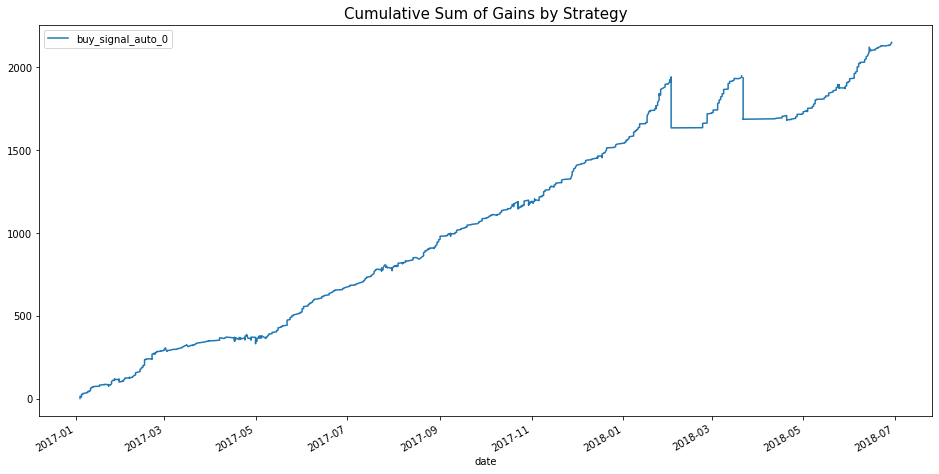

In [287]:
colors = ['red', 'green', 'blue', 'black', 'orange', 'pink', 'purple']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(pair_of_signals):
    rgl_df[rgl_df['strategy'] == signal[0]]['$_gain'].cumsum().plot(figsize=(16,8), label=signal[0])#, color=colors[idx])

plt.legend()
plt.title('Cumulative Sum of Gains by Strategy', size=15);

## Sum of Non Realized Gains

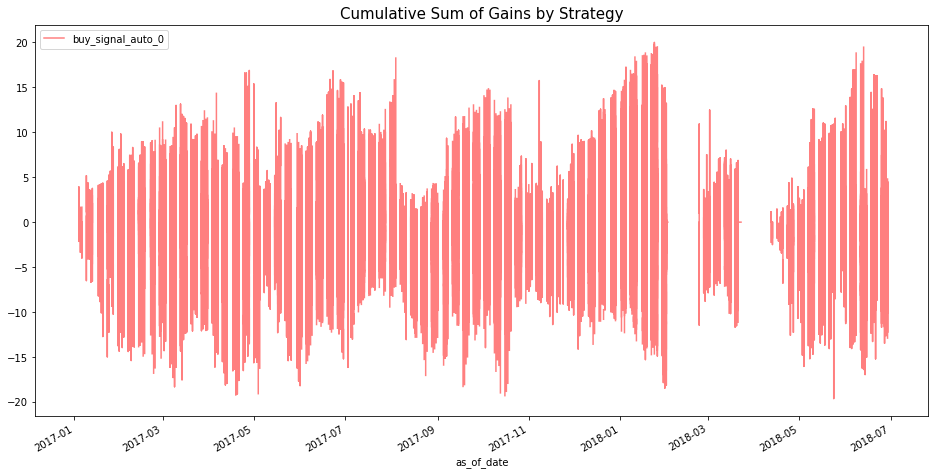

In [288]:
fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(pair_of_signals):
    holdings_df[holdings_df['strategy'] == signal[0]]['$_gain'].plot(figsize=(16,8), color=colors[idx], label=signal[0], alpha=0.5)

plt.legend()
plt.title('Cumulative Sum of Gains by Strategy', size=15);

### Holdings - Cash not Included

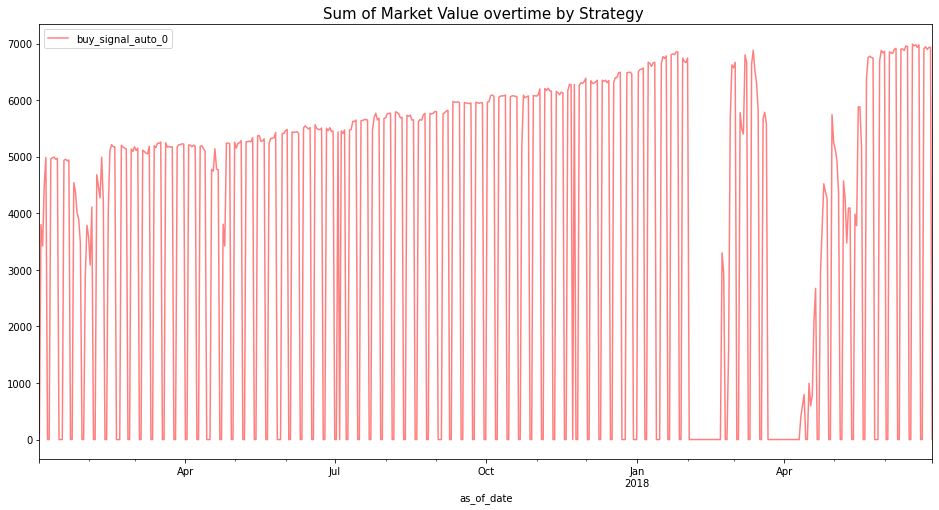

In [289]:
fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(pair_of_signals):
    holdings_df[holdings_df['strategy'] == signal[0]].groupby(level=0).sum()['market_value'].plot(figsize=(16,8), color=colors[idx], label=signal[0], alpha=0.5)

plt.legend()
plt.title('Sum of Market Value overtime by Strategy ', size=15);


## Cash Balance overtime

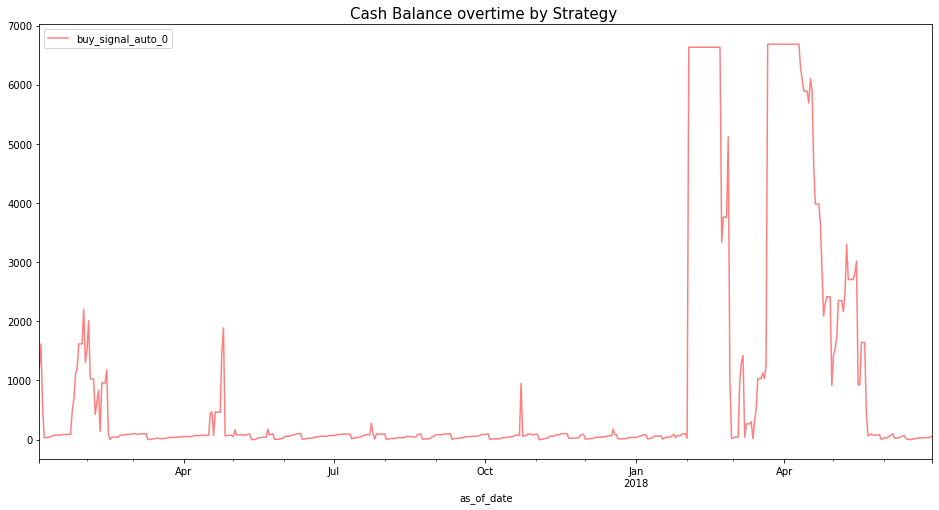

In [290]:
fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(pair_of_signals):
    balances_df[balances_df['strategy'] == signal[0]].groupby(level=0).sum()['market_value'].plot(figsize=(16,8), color=colors[idx], label=signal[0], alpha=0.5)

plt.legend()
plt.title('Cash Balance overtime by Strategy ', size=15);


## Holdings + Cash

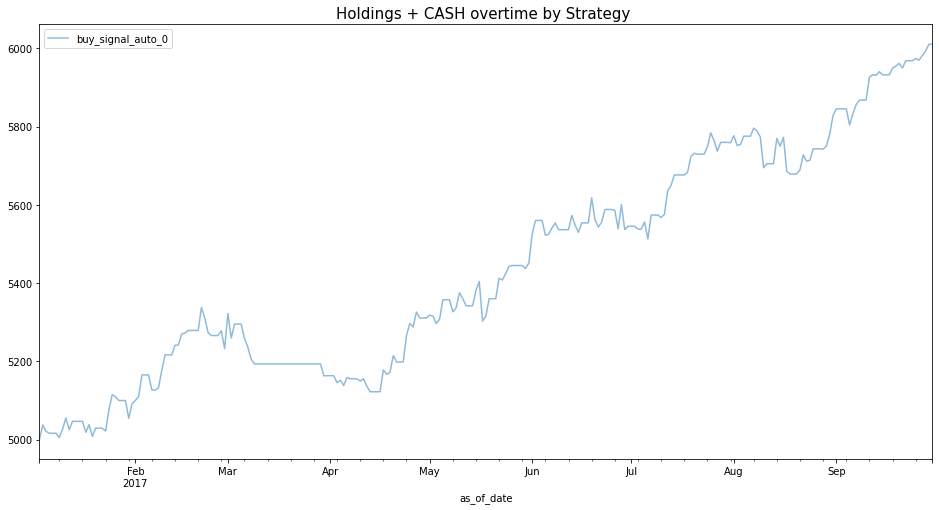

In [261]:
fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(pair_of_signals):
    a = balances_df[balances_df['strategy'] == signal[0]].groupby(level=0).sum()['market_value'].reset_index()
    b = holdings_df[holdings_df['strategy'] == signal[0]].groupby(level=0).sum()['market_value'].reset_index()
    b.replace(0, np.NaN, inplace=True)
    a.columns = ['as_of_date', 'cash_balance']
    plot_me = pd.merge(a,b,how='left', on='as_of_date')
    plot_me['total'] = plot_me['cash_balance'] + plot_me['market_value']
    plot_me['cash_diff'] = plot_me['cash_balance'].diff()
    plot_me['market_value'].mask(((plot_me['cash_diff'] / 100) > 5) & (plot_me['market_value'].isnull()), 0, inplace=True)
    plot_me['market_value'] = plot_me['market_value'].ffill()
    plot_me.set_index('as_of_date', inplace=True)
    plot_me['total'] = plot_me['cash_balance'] + plot_me['market_value']
    plot_me['total'].plot(figsize=(16,8), label=signal[0], alpha=0.5, linestyle = '-')#, color=colors[idx] )

plt.legend()
plt.title('Holdings + CASH overtime by Strategy ', size=15);


## Invested Money overtime

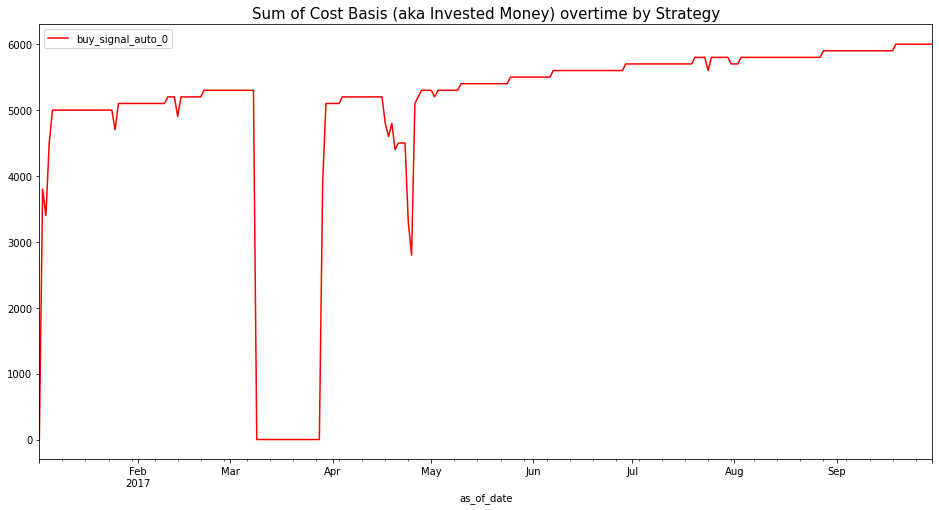

In [262]:
fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(pair_of_signals):
    holdings_df[holdings_df['strategy'] == signal[0]].groupby(level=0).sum()['cost_basis'].plot(figsize=(16,8), color=colors[idx], label=signal[0])

plt.legend()
plt.title('Sum of Cost Basis (aka Invested Money) overtime by Strategy', size=15);

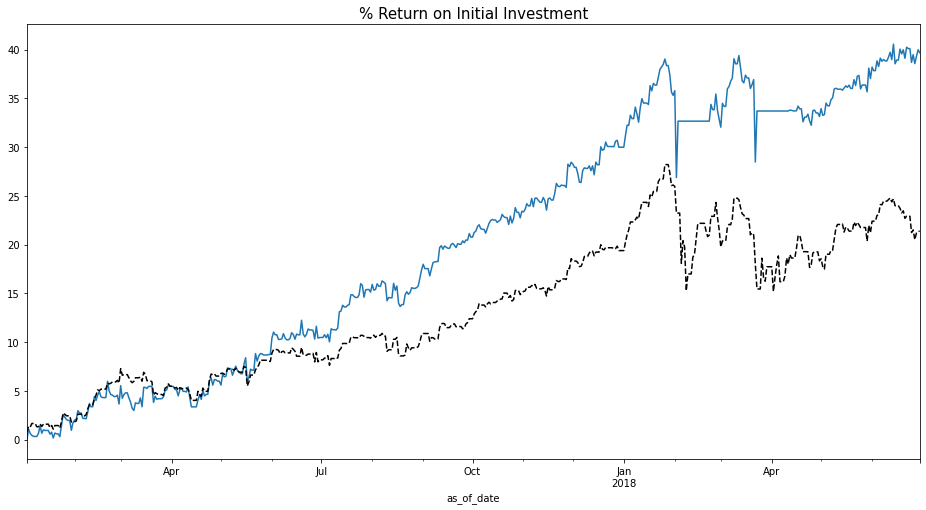

In [291]:
for idx, signal in enumerate(pair_of_signals):
    # Calulate gains, current_holdings and balances
    gains = rgl_df[rgl_df['strategy'] == signal[0]].fillna(0).groupby(level=0).sum()['$_gain'].reset_index()
    current_holdings = holdings_df[(holdings_df['strategy'] == signal[0])].groupby(level=0).sum()['market_value'].reset_index().replace(0, np.NaN)
    current_balance = balances_df[(balances_df['strategy'] == signal[0])].groupby(level=0).sum()['market_value'].reset_index()
    
    # Rename columns for balances
    current_balance.columns = ['as_of_date', 'cash_balance']
    
    # Create data_frame to plot
    to_plot = pd.merge(current_balance, current_holdings, how='left', on='as_of_date')
    to_plot['cash_diff'] = to_plot['cash_balance'].diff()
    #to_plot['market_value'].mask((to_plot['cash_diff'] / how_much) > 5, 0, inplace=True)
    
    # Forward Fill
    to_plot['total'] = to_plot['market_value'] + to_plot['cash_balance']
    to_plot['total_diff'] = to_plot['total'].diff(2)
    to_plot['market_value'].mask((to_plot['market_value'].isnull() == True)
                                 & (to_plot['cash_balance'] / to_plot['cash_diff'] > 0.9)
                                 & (to_plot['cash_diff'] != 0), 0, inplace=True)
    to_plot['market_value'] = to_plot['market_value'].ffill()
    
    to_plot = pd.merge(to_plot, gains, how='left', left_on='as_of_date', right_on='date')
    
    # calculate total
    to_plot.fillna(0, inplace=True)
    to_plot['%_return'] = 100*(((to_plot['$_gain'] + to_plot['market_value'] + to_plot['cash_balance']) / 5000) - 1)
    to_plot.set_index('as_of_date', inplace=True)
    
    to_plot['%_return'].plot(figsize=(16,8), label=signal[0])#, color=colors[idx])
    
    # Calculate Monthly Returns
    monthly = to_plot.reset_index()
    monthly['total_mv'] = monthly['cash_balance'] + monthly['market_value']
    monthly['day'] = monthly['as_of_date'].dt.day
    monthly['day'] = monthly['day'].shift(-1)
    monthly = monthly[monthly['day'] == 1]
    monthly['previous_mv'] = monthly['total_mv'].shift(1)
    monthly['monthly_return'] = 100 * ((monthly['total_mv'] / monthly['previous_mv']) - 1)
    column_name = signal[0] + '_monthly_return'
    if idx == 0: 
        monthly_master = monthly[['as_of_date', 'monthly_return']]
        monthly_master.columns = ['as_of_date', column_name]
    else:
        temp = monthly[['as_of_date', 'monthly_return']]
        temp.columns = ['as_of_date', column_name]
        monthly_master = pd.merge(monthly_master, temp, how='left', on='as_of_date')
    
# benchmark
to_plot_sp = pd.merge(to_plot, sp, left_index=True, right_index=True, how='left')
to_plot_sp['daily_returns'] = to_plot_sp['daily_returns'].fillna(1)
to_plot_sp['running_return'] = (to_plot_sp['daily_returns'].cumprod() - 1) * 100
to_plot_sp['running_return'].plot(figsize=(16,8), color='black', label='S&P', linestyle = '--')

# calculate monthly returns
sp500 = to_plot_sp.reset_index()
sp500['month'] = sp500['as_of_date'].dt.month
sp500['year'] = sp500['as_of_date'].dt.year
sp500['day'] = sp500['as_of_date'].dt.day
sp500['day_shift'] = sp500['day'].shift(-1)
monthly_returns = sp500.groupby(['year','month']).prod()['daily_returns'].reset_index()
monthly_returns.columns = ['year', 'month', 'sp500_monthly_returns']
monthly_returns['sp500_monthly_returns'] = 100 * (monthly_returns['sp500_monthly_returns'] - 1)
sp500 = pd.merge(sp500, monthly_returns, on=['year', 'month'])
sp500 = sp500[sp500['day_shift'] == 1][['as_of_date', 'sp500_monthly_returns']]
monthly_master = pd.merge(monthly_master, sp500, on='as_of_date')
    
#plt.legend()
plt.title('% Return on Initial Investment', size=15);
    

In [279]:
for column in monthly_master.columns:
    if 'return' in column:
        x = ((monthly_master[(monthly_master['as_of_date'] > '2017-02-01') & 
                             (monthly_master['as_of_date'] < '2020-11-30')][column] / 100) + 1).cumprod().iloc[-1:].values[0]
        print(column, x)

buy_signal_auto_0_monthly_return 1.3560815686673353
sp500_monthly_returns 1.1907880450709984


In [280]:
to_plot

cash_balance  market_value    cash_diff        total  total_diff  \
as_of_date                                                                     
2017-01-03   1200.000000   3800.000000     0.000000  5000.000000    0.000000   
2017-01-04   1615.922274   3421.254091   415.922274  5037.176365    0.000000   
2017-01-05    526.521927   4494.126492 -1089.400348  5020.648418   20.648418   
2017-01-06     31.770317   4984.197465  -494.751609  5015.967782  -21.208583   
2017-01-07     31.770317   4984.197465     0.000000     0.000000    0.000000   
2017-01-08     31.770317   4984.197465     0.000000     0.000000    0.000000   
2017-01-09     42.636517   4962.161745    10.866200  5004.798262    0.000000   
2017-01-10     47.210466   4979.323369     4.573948  5026.533835    0.000000   
2017-01-11     64.017847   4991.220293    16.807382  5055.238140   50.439878   
2017-01-12     71.148342   4954.131166     7.130495  5025.279508   -1.254327   
2017-01-13     74.295827   4972.197595     3.147485  5046.493422   -8.744718   
2017-01-14     74.295827   4972.197595     0.000000     0.000000    0.000000   
2017-01-15     74.295827   4972.197595     0.000000     0.000000    0.000000   
2017-01-16     74.295827   4972.197595     0.000000     0.000000    0.000000   
2017-01-17     82.921136   4935.765593     8.625309  5018.686729    0.000000   
2017-01-18     82.921136   4954.949345     0.000000  5037.870481    0.000000   
2017-01-19     82.921136   4924.969863     0.000000  5007.890999  -10.795730   
2017-01-20     87.198514   4941.847070     4.277378  5029.045584   -8.824897   
2017-01-21     87.198514   4941.847070     0.000000     0.000000    0.000000   
2017-01-22     87.198514   4941.847070     0.000000     0.000000    0.000000   
2017-01-23    -19.567347   5041.005249  -106.765861  5021.437903    0.000000   
2017-01-24    183.138303   4894.074820   202.705650  5077.213123    0.000000   
2017-01-25   1012.591230   4104.186708   829.452927  5116.777938   95.340035   
2017-01-26    123.352284   4990.653415  -889.238946  5114.005699   36.792575   
2017-01-27    528.578224   4575.814681   405.225940  5104.392905  -12.385032   
2017-01-28    528.578224   4575.814681     0.000000     0.000000    0.000000   
2017-01-29    528.578224   4575.814681     0.000000     0.000000    0.000000   
2017-01-30   1313.759917   3751.750867   785.181693  5065.510785    0.000000   
2017-01-31   1414.914652   3680.276255   101.154734  5095.190907    0.000000   
2017-02-01   -373.146168   5467.118438 -1788.060820  5093.972269   28.461485   
2017-02-02    -71.715677   5171.071200   301.430492  5099.355523    4.164617   
2017-02-03   1353.559640   3800.951108  1425.275317  5154.510748   60.538479   
2017-02-04   1353.559640   3800.951108     0.000000     0.000000    0.000000   
2017-02-05   1353.559640   3800.951108     0.000000     0.000000    0.000000   
2017-02-06   1753.667208   3375.369803   400.107568  5129.037011    0.000000   
2017-02-07   -843.638636   5974.396668 -2597.305844  5130.758032    0.000000   
2017-02-08   -741.078724   5867.349347   102.559912  5126.270624   -2.766388   
2017-02-09    381.696550   4789.891399  1122.775273  5171.587949   40.829917   
2017-02-10   -408.833932   5602.184275  -790.530482  5193.350343   67.079720   
2017-02-11   -408.833932   5602.184275     0.000000     0.000000    0.000000   
2017-02-12   -408.833932   5602.184275     0.000000     0.000000    0.000000   
2017-02-13    107.131083   5103.384331   515.965015  5210.515413    0.000000   
2017-02-14     18.123162   5205.520616   -89.007921  5223.643778    0.000000   
2017-02-15     32.080028   5223.369596    13.956866  5255.449624   44.934211   
2017-02-16     59.487692   5195.552627    27.407663  5255.040319   31.396541   
2017-02-17     64.901967   5183.835832     5.414275  5248.737799   -6.711826   
2017-02-18     64.901967   5183.835832     0.000000     0.000000    0.000000   
2017-02-19     64.901967   5183.835832     0.000000     0.000000    0.000000   
2017-02-20  

# Sharpe Ratio

In [235]:
monthly_master = monthly_master.dropna()
risk_free_rate = 0.03

for column in monthly_master.columns:
    if 'buy_signal' in column:
        # Calculate start month of strategy
        start_month = monthly_master[monthly_master[column] != 0]['as_of_date'].min()
        start_number = monthly_master[monthly_master['as_of_date'] == start_month].index[0]
        
        # Total Number of months where we have returns
        no_of_months = len(monthly_master) - start_number + 1
        
        # Running return and Annualized return
        total_return = ((monthly_master[column]  / 100) + 1).cumprod().iloc[-1:].values[0]
        annualized_return = (total_return ** (12/no_of_months)) - 1
        
        # Calculate Std Deviation
        std_dev = ((monthly_master[column] / 100).iloc[start_number:]).std()
        
        # Sharpe Ratio
        sharpe_ratio = (annualized_return - risk_free_rate) / std_dev
        print(column, round(sharpe_ratio,2))

buy_signal_auto_0_monthly_return 3.93


### Monthly Returns

In [35]:
lst_columns = list(monthly_master.columns)
lst_columns.remove('as_of_date')
pd.melt(monthly_master, id_vars=['as_of_date'], value_vars=lst_columns)#.to_csv('reno.csv')#.to_csv('results/' + filename)

as_of_date                          variable     value
0  2017-02-28  buy_signal_auto_0_monthly_return  1.796182
1  2017-03-31  buy_signal_auto_0_monthly_return -0.785576
2  2017-04-30  buy_signal_auto_0_monthly_return  2.220708
3  2017-05-31  buy_signal_auto_0_monthly_return  1.848770
4  2017-06-30  buy_signal_auto_0_monthly_return  0.170718
5  2017-07-31  buy_signal_auto_0_monthly_return  3.722612
6  2017-08-31  buy_signal_auto_0_monthly_return  1.086977
7  2017-09-30  buy_signal_auto_0_monthly_return  2.524803
8  2017-10-31  buy_signal_auto_0_monthly_return  3.285353
9  2017-11-30  buy_signal_auto_0_monthly_return  2.190582
10 2017-12-31  buy_signal_auto_0_monthly_return  1.016231
11 2018-01-31  buy_signal_auto_0_monthly_return  5.244623
12 2018-02-28  buy_signal_auto_0_monthly_return -3.534244
13 2018-03-31  buy_signal_auto_0_monthly_return  0.807959
14 2018-04-30  buy_signal_auto_0_monthly_return  1.506993
15 2018-05-31  buy_signal_auto_0_monthly_return  1.601740
16 2018-06-30  buy_signal_auto_0_monthly_return  0.441073
17 2018-07-31  buy_signal_auto_0_monthly_return  0.375471
18 2018-08-31  buy_signal_auto_0_monthly_return  5.265118
19 2018-09-30  buy_signal_auto_0_monthly_return -0.635449
20 2018-10-31  buy_signal_auto_0_monthly_return -6.032788
21 2018-11-30  buy_signal_auto_0_monthly_return  0.414183
22 2017-02-28             sp500_monthly_returns  3.929153
23 2017-03-31             sp500_monthly_returns -0.308705
24 2017-04-30             sp500_monthly_returns  0.992617
25 2017-05-31             sp500_monthly_returns  1.411291
26 2017-06-30             sp500_monthly_returns  0.149106
27 2017-07-31             sp500_monthly_returns  2.055418
28 2017-08-31             sp500_monthly_returns  0.291770
29 2017-09-30             sp500_monthly_returns  1.511168
30 2017-10-31             sp500_monthly_returns  2.356406
31 2017-11-30             sp500_monthly_returns  3.056588
32 2017-12-31             sp500_monthly_returns  0.698078
33 2018-01-31             sp500_monthly_returns  5.635917
34 2018-02-28             sp500_monthly_returns -3.636041
35 2018-03-31             sp500_monthly_returns -3.129026
36 2018-04-30             sp500_monthly_returns  0.516822
37 2018-05-31             sp500_monthly_returns  2.430907
38 2018-06-30             sp500_monthly_returns  0.125488
39 2018-07-31             sp500_monthly_returns  3.704655
40 2018-08-31             sp500_monthly_returns  3.191985
41 2018-09-30             sp500_monthly_returns  0.141230
42 2018-10-31             sp500_monthly_returns -6.910428
43 2018-11-30             sp500_monthly_returns  1.854927

In [290]:
summ = 0
lst = [2,3,4,5]
for element in lst:
    print(element**3)
    summ += element**3

8
27
64
125


In [328]:
sting = "Flatiron prepares students to succeed."
sting.title().replace('r', 'i').replace('.', '!').strip(" ")

'Flatiion Piepaies Students To Succeed!'

In [311]:
import numpy as np

In [337]:
def g(x):
    return 1/x
def f(x):
    return (2*x) + 1

In [338]:
f(g(2))

2.0

In [329]:
lst = [0.86, 1.65, 1.61, 0.68, 1.08,
0.75, 2.81, 4.41, 0.29, 0.50,
6.71, 0.22, 0.24, 4.26, 2.66,
0.18, 0.33, 0.14, 2.00, 0.63]

In [73]:
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
import time

driver = webdriver.Chrome()
delay = 20
close_time = time.time()+delay

driver.get("https://cpstest.org/")

driver.maximize_window()


time.sleep(5)

#element = driver.find_element_by_id('clicker')
#actions = ActionChains(driver)
#actions.move_to_element(element).perform()

while True:
    python_button = driver.find_elements_by_xpath("/html/body/div[1]/div[3]/div/div[2]/div[1]/div[2]/div[1]")[0]
    python_button.click()
    if time.time()>close_time:
        break

time.sleep(5)

retry_button = driver.find_elements_by_xpath("/html/body/div[3]/div/div/div[1]/button")[0]
driver.execute_script("arguments[0].click();", retry_button)

time.sleep(5)

driver.quit()

SessionNotCreatedException: Message: session not created: This version of ChromeDriver only supports Chrome version 83


In [68]:
product_array_special([1,2,3,4,5])

[120, 60, 40, 30, 24]

4